# Case Study: Churn

In this case study we try to create an answer why customers have left our service, a telecom operator.

The case study is divided into several parts:
- Goals
- Parsing
- Preparation (cleaning)
- Processing
- Exploration
- Visualization
- Conclusion

## Goals

In this section we define questions that will be our guideline througout the case study

- Why are customers leaving us?
- Can we cluster types of customers?

We'll (try to) keep these question in mind when performing the case study.

## Parsing

we start out by importing all libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats
import sklearn
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
%matplotlib inline

in order to download datasets from kaggle, we need an API key to access their API, we'll make that here

In [2]:
if not os.path.exists(os.path.expanduser('~/.kaggle')):
    os.mkdir(os.path.expanduser('~/.kaggle'))

with open(os.path.expanduser('~/.kaggle/kaggle.json'), 'w') as f:
    json.dump(
        {
            "username":"lorenzf",
            "key":"7a44a9e99b27e796177d793a3d85b8cf"
        }
        , f)

now we can import kaggle too and download the datasets

In [3]:
import kaggle
kaggle.api.dataset_download_files(dataset='blastchar/telco-customer-churn', path='./data', unzip=True)

ModuleNotFoundError: No module named 'kaggle'

the csv files are now in the './data' folder, we can now read them using pandas, here is the list of all csv files in our folder

In [4]:
os.listdir('./data')

['WA_Fn-UseC_-Telco-Customer-Churn.csv']

This dataset only contains 1 file, in it each row has all the information about a single customer and which services he or she has or had before churning.

In [5]:
churn_df = pd.read_csv('./data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
print('shape: ' + str(churn_df.shape))
churn_df.head()

shape: (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Looks like there is some personal info and the configuration of the service, such as if they had an internet service, with or without options such as security, backup,...
By the lookds of it these Yes/No answers are not booleans (i.e. 2 options) but rather categories as they have a third option, 'No ... service'.

## Preparation

here we perform tasks to prepare the data in a more pleasing format.

### Data Types

Before we do anything with our data, it is good to see if our data types are in order

In [6]:
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


I am opting to change the sernior citizan from 0/1 to No/Yes and convert them all to categories, let's do that right now.

In [7]:
churn_df.SeniorCitizen = churn_df.SeniorCitizen.map({0: 'No', 1:'Yes'})
churn_df[['gender', 'SeniorCitizen', 'Partner','Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']] = churn_df[['gender', 'SeniorCitizen', 'Partner','Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']].astype('category')
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

Now our yes/no answers are configured as categories, for numbers we see that there are 2: 'MontlyCharges' and 'TotalCharges'.
I'm going to make them floating numbers

In [8]:
churn_df[['MonthlyCharges', 'TotalCharges']] = churn_df[['MonthlyCharges', 'TotalCharges']].astype('float')
churn_df.info()

ValueError: could not convert string to float: ''

Looks like we have encountered some problems, there are strings in the Total charges that are not able to be converted to a decimal number.
We print out the rows that create an error and observe.

In [9]:
churn_df[pd.to_numeric(churn_df.TotalCharges,errors='coerce').isna()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No
753,3115-CZMZD,Male,No,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No
936,5709-LVOEQ,Female,No,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,No
1082,4367-NUYAO,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No
1340,1371-DWPAZ,Female,No,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No
3331,7644-OMVMY,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No
3826,3213-VVOLG,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No
4380,2520-SGTTA,Female,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No
5218,2923-ARZLG,Male,No,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No
6670,4075-WKNIU,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,No


Seems that there are some customers being so new they have no total charges, for convenience i'm going to change the space to a 0.

In [10]:
churn_df.TotalCharges = churn_df.TotalCharges.replace(' ', '0')

In [11]:
churn_df[['MonthlyCharges', 'TotalCharges']] = churn_df[['MonthlyCharges', 'TotalCharges']].astype('float')
churn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   customerID        7043 non-null   object  
 1   gender            7043 non-null   category
 2   SeniorCitizen     7043 non-null   category
 3   Partner           7043 non-null   category
 4   Dependents        7043 non-null   category
 5   tenure            7043 non-null   int64   
 6   PhoneService      7043 non-null   category
 7   MultipleLines     7043 non-null   category
 8   InternetService   7043 non-null   category
 9   OnlineSecurity    7043 non-null   category
 10  OnlineBackup      7043 non-null   category
 11  DeviceProtection  7043 non-null   category
 12  TechSupport       7043 non-null   category
 13  StreamingTV       7043 non-null   category
 14  StreamingMovies   7043 non-null   category
 15  Contract          7043 non-null   category
 16  PaperlessBilling  7043 n

### Missing values

for each dataframe we apply a few checks in order to see the quality of data

In [12]:
print(100*churn_df.isna().sum()/churn_df.shape[0])

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64


No missing values (if we do not count the ones we solved earlier), sometimes luck is on our side.

### Duplicates

For any reason, our dataset might be containing duplicates that would be counted twice and will introduce a bias we would not want. On the other hand, duplicates can be subjected to interpretation, here we would say that if 2 records are completely the same they are duplicates.

In [13]:
churn_df.duplicated().any()

False

### Indexing

It is more convenient to work with an index, our dataset already contains an id which we can use as index

In [14]:
churn_df = churn_df.set_index('customerID')
churn_df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,No,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,No,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
3668-QPYBK,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,No,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,No,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Processing

### Churn vs no churn
I would like to compare between persons that have churned and others, therefore a function that calculates the counts between churn and a given column would be convenient.
By using functions I keep things dynamic without having to store a dataframe for each column, but static dataframes work equally well!

In [15]:
def count_matrix(col_name):
    return churn_df.groupby(['Churn', col_name]).size().unstack()

In [16]:
count_matrix('DeviceProtection')

DeviceProtection,No,No internet service,Yes
Churn,,,
No,1884,1413,1877
Yes,1211,113,545


aside from the counts I would also like to know the mean, as some groups have a smaller population yet their proportion of churned persons might be higher.

In [17]:
def mean_matrix(col_name):
    df = churn_df.groupby(['Churn', col_name]).size().unstack()
    return df.divide(df.sum(axis='index'),axis='columns')

In [18]:
mean_matrix('DeviceProtection')

DeviceProtection,No,No internet service,Yes
Churn,,,
No,0.608724,0.92595,0.774979
Yes,0.391276,0.07405,0.225021


out of curiosity, let's print all those 'mean matrices'

In [19]:
for col in churn_df.columns.drop('Churn'):
  print(mean_matrix(col))
  print()

gender    Female      Male
Churn                     
No      0.730791  0.738397
Yes     0.269209  0.261603

SeniorCitizen        No       Yes
Churn                            
No             0.763938  0.583187
Yes            0.236062  0.416813

Partner       No       Yes
Churn                     
No       0.67042  0.803351
Yes      0.32958  0.196649

Dependents        No       Yes
Churn                         
No          0.687209  0.845498
Yes         0.312791  0.154502

tenure   0         1         2     3         4         5         6         7   \
Churn                                                                           
No      1.0  0.380098  0.483193  0.53  0.528409  0.518797  0.636364  0.610687   
Yes     0.0  0.619902  0.516807  0.47  0.471591  0.481203  0.363636  0.389313   

tenure        8         9   ...        63    64        65        66        67  \
Churn                       ...                                                 
No      0.658537  0.613445  ...  

We already see some big differences between populations of churn and no churn for some of these features, promising!

### one hot encoding
I would also like to run the data into an algorithm, yet computers don't like categories, so I 'one hot encode' the categories and get a column/feature for each category in my categorical variables.

In [20]:
churn_ohe_df = pd.concat(
    [
     pd.get_dummies(churn_df.drop(columns=['Churn'])),
     churn_df.Churn.eq('Yes').astype(int)
    ], axis='columns'
)
churn_ohe_df.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_No,SeniorCitizen_Yes,Partner_No,Partner_Yes,Dependents_No,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,1,29.85,29.85,1,0,1,0,0,1,1,...,1,0,0,0,1,0,0,1,0,0
5575-GNVDE,34,56.95,1889.50,0,1,1,0,1,0,1,...,0,1,0,1,0,0,0,0,1,0
3668-QPYBK,2,53.85,108.15,0,1,1,0,1,0,1,...,1,0,0,0,1,0,0,0,1,1
7795-CFOCW,45,42.30,1840.75,0,1,1,0,1,0,1,...,0,1,0,1,0,1,0,0,0,0
9237-HQITU,2,70.70,151.65,1,0,1,0,1,0,1,...,1,0,0,0,1,0,0,1,0,1


### correlation
I went ahead and already calculated the correlation matrix for this dataset, with the ohe version of the data we can figure out which categories are related.
In the next cell I printed out all correlations with the churn feature.

In [21]:
churn_corr_df = churn_ohe_df.corr()
churn_corr_df['Churn']

tenure                                    -0.352229
MonthlyCharges                             0.193356
TotalCharges                              -0.198324
gender_Female                              0.008612
gender_Male                               -0.008612
SeniorCitizen_No                          -0.150889
SeniorCitizen_Yes                          0.150889
Partner_No                                 0.150448
Partner_Yes                               -0.150448
Dependents_No                              0.164221
Dependents_Yes                            -0.164221
PhoneService_No                           -0.011942
PhoneService_Yes                           0.011942
MultipleLines_No                          -0.032569
MultipleLines_No phone service            -0.011942
MultipleLines_Yes                          0.040102
InternetService_DSL                       -0.124214
InternetService_Fiber optic                0.308020
InternetService_No                        -0.227890
OnlineSecuri

We can see that complementary categories show an inverse correlation, indicating that we are dealing with a excess of information.
Logical as when option A is not chosen, option B is.
However in this case, as some categoricals have 3 options I opt to keep all info, although it would be a good idea to remove 1 option for each category, this should become appearent in data exploration.

## Exploration

Here we start with the exploration of our dataset, we look into normal distribution of numerical data, categorical correlations, numerical and categorical correlation, cluster results, and a simple machine learning implementation.

### Normal distribution

As a precaution I will check the normality of our numerical data.
Although most probably not essential for further analysis it might be useful later.

In [22]:
for name, col in churn_df[['tenure', 'MonthlyCharges', 'TotalCharges']].iteritems():
    print(name)
    print(scipy.stats.shapiro(col.dropna()))

tenure
ShapiroResult(statistic=0.9037491083145142, pvalue=0.0)
MonthlyCharges
ShapiroResult(statistic=0.9208902716636658, pvalue=0.0)
TotalCharges
ShapiroResult(statistic=0.8601524233818054, pvalue=0.0)


/home/lorenzf/.local/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


It is clear that our numerical data is not normally distributed, as mentioned not essential, therefore I will not be transforming the data and keeping it as it is. This is useful later because we keep the meaning of the values.

### Categorical correlations

We have a lot of categorical features that could correlate with our Churn parameter, for each of those we would like to know how strong their correlation is. We can use the count_matrix function we created earlier for this.

In [23]:
count_matrix('DeviceProtection')

DeviceProtection,No,No internet service,Yes
Churn,,,
No,1884,1413,1877
Yes,1211,113,545


Using the Chi Squared Contingency test we can find out if any category of the chosen feature correlates with our Churn feature. it returns the test statistic F (strength of correlation), the p-value (chance of correlation) and expected values if no correlation is present.

In [24]:
F, p, df, exp = scipy.stats.chi2_contingency(count_matrix('DeviceProtection'))

Something I find interesting is to subtract the expected values from the true values, this case we see where the surplusses are.

In [25]:
count_matrix('DeviceProtection') - exp

DeviceProtection,No,No internet service,Yes
Churn,,,
No,-389.68025,291.954423,97.725827
Yes,389.68025,-291.954423,-97.725827


To make our lives simpler, we extract all the categorical columns that we want to test against the Churn feature.

In [26]:
cat_cols = churn_df.columns.drop(['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges'])
cat_cols

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod'],
      dtype='object')

Here I've written a small script that for each of those columns performs the Chi Squared test and writes the results down.

In [27]:
significant_cols = []
chi2_results = {}
for col in cat_cols:
    counts = count_matrix(col)
    F, p, df, exp = scipy.stats.chi2_contingency(counts)
    if p<0.05:
        significant_cols.append(col)
        chi2_results[col] = {
            'F': F,
            'p': p,
            'real': counts,
            'exp': exp,
            'diff': counts - exp,
        }
            
# sort in descending F value
chi2_results = {x[0]: x[1] for x in sorted(chi2_results.items(), key=lambda x: x[1]['F'], reverse=True)}

The features that are significant have a p-value less than 0.05, indicating only a 5% chance that this occurs randomly. We list them here

In [28]:
significant_cols

['SeniorCitizen',
 'Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

Lets zoom into one of them, here we print the difference of the true values and the expected

In [29]:
chi2_results['SeniorCitizen']['diff']

SeniorCitizen,No,Yes
Churn,,
No,172.947608,-172.947608
Yes,-172.947608,172.947608


We can see that there are about 173 persons more in the group of SeniorCitizen that have Churned than was expected. Perhaps the provided service was not Senior friendly?

In [30]:
mean_matrix('SeniorCitizen')*100

SeniorCitizen,No,Yes
Churn,,
No,76.393832,58.318739
Yes,23.606168,41.681261


We can see the same pattern in our mean matrix, from the Senior Citizens about 18% more have churned than the non SeniorCitizen group! To make things more easier on the eye I've put it into a dataframe that is sorted by correlation strength

In [31]:
corr_df = pd.DataFrame(
    {
        'p': [chi2_results[col]['p'] for col in significant_cols],
        'F': [chi2_results[col]['F'] for col in significant_cols]
    }
    , index=significant_cols).sort_values('F', ascending=False)

We can see that features such as Contract type, OnlineSecurity and TechSupport have a strong correlation with Churning.

### Numerical vs Categorical correlation

Next we would like to know if numerical features have a correlation with our Churn, using ANOVA we can mathematically calculate this. First let's look at the averages of tenure between Yes and No Churn.

In [32]:
churn_df.groupby('Churn').tenure.mean()

Churn
No     37.569965
Yes    17.979133
Name: tenure, dtype: float64

This is already a clear difference, but let's not jump to conclusion, ANOVA also takes into account group sizes and variation.

In [33]:
scipy.stats.f_oneway(
    churn_df[churn_df.Churn=='Yes'].tenure, 
    churn_df[churn_df.Churn=='No'].tenure
)

F_onewayResult(statistic=997.2680104991438, pvalue=7.999057960610892e-205)

That p-values sure does speak for itself, there is a clear difference in tenures for users that have churned and others!

### unsupervised clustering

Our customers also asked us to find out if we can find specific clusters of users in their dataset, so we perform a clustering analysis.

In [34]:
from sklearn.cluster import KMeans

We create a clustering algorithm and specify that we would like to have 2 clusters, perhaps they will overlap with churn and nochurn. Then we fit the algorithm with our dataset without the churn feature.

In [35]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(churn_ohe_df.drop(columns=['Churn']))

KMeans(n_clusters=2)

After training on the dataset we can ask it to give us the labels for each record that it assigned, [0, 1] are the 2 clusters that it used to seperate our data.

In [36]:
kmeans.labels_

array([0, 0, 0, ..., 0, 0, 1], dtype=int32)

Great! Now we just have to do some data manipulation by adding the labels as a new feature to a new dataframe. We end up with churn_cluster_df, the same as churn_df but with an unsupervised clustering label.

In [37]:
churn_cluster_df = churn_df.copy()
churn_cluster_df['cluster'] = kmeans.labels_
#churn_cluster_df[['dist_0', 'dist_1']] = kmeans.transform(churn_ohe_df.drop(columns='Churn'))

We can calculate a comparison matrix, where for each combination of churn and cluster we count how many records there are.

In [38]:
churn_cluster_df.groupby(['Churn','cluster']).size().unstack()

cluster,0,1
Churn,,
No,3404,1770
Yes,1547,322


Looks like the overlap is not as clear as we would have expect it, this is common in unsupervised techniques as we did not specify the Churn feature to the algorithm. This does not imply our work is useless as it might give other insight to our data.

Same for the regular data we create 2 functions that aggregate our data based on a specific column name.

In [39]:
def count_cluster_matrix(col_name):
    return churn_cluster_df.groupby(['cluster', col_name]).size().unstack()

def mean_cluster_matrix(col_name):
    df = churn_cluster_df.groupby(['cluster', col_name]).size().unstack()
    return df.divide(df.sum(axis='index'),axis='columns')

As an example we count the occurences of Device Protection with our clusters

In [40]:
count_cluster_matrix('DeviceProtection')

DeviceProtection,No,No internet service,Yes
cluster,,,
0,2432,1526,993
1,663,0,1429


Cluster 1 seems to not contains any users that did not have internet access, so we can already see that this cluster only contains users with internet and mostly have device protection.

To automate results, we again perform the contingency analysis, this time on the cluster feature instead of the churn feature.

In [41]:
cl_significant_cols = []
cl_chi2_results = {}
for col in churn_cluster_df.columns.drop('Churn'):
    counts = count_cluster_matrix(col)
    F, p, df, exp = scipy.stats.chi2_contingency(counts)
    if p<0.05:
        cl_significant_cols.append(col)
        cl_chi2_results[col] = {
            'F': F,
            'p': p,
            'real': counts,
            'exp': exp,
            'diff': counts - exp,
        }
        
# sort in descending F value
cl_chi2_results = {x[0]: x[1] for x in sorted(cl_chi2_results.items(), key=lambda x: x[1]['F'], reverse=True)}

The significant columns can be completely different, yet seem fairly similar

In [42]:
cl_significant_cols

['SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod']

We ask for the difference, which only seems to be the PhoneService, this feature is important for the clusters but not the churning.

In [43]:
set(cl_significant_cols).difference(significant_cols)

{'PhoneService'}

To get a better picture I opted to print all the significant results in order of correlation strenght. Both for Churn as for cluster.

In [44]:
print('Churn significant features')
{col: result['F'] for col, result in chi2_results.items()}

Churn significant features


{'Contract': 1184.5965720837926,
 'OnlineSecurity': 849.9989679615962,
 'TechSupport': 828.1970684587393,
 'InternetService': 732.309589667794,
 'PaymentMethod': 648.1423274814,
 'OnlineBackup': 601.8127901134089,
 'DeviceProtection': 558.419369407389,
 'StreamingMovies': 375.6614793452656,
 'StreamingTV': 374.20394331098134,
 'PaperlessBilling': 258.27764906707307,
 'Dependents': 189.12924940423474,
 'SeniorCitizen': 159.42630036838742,
 'Partner': 158.7333820309922,
 'MultipleLines': 11.33044148319756}

In [45]:
print('Cluster significant features')
{col: result['F'] for col, result in cl_chi2_results.items()}

Cluster significant features


{'DeviceProtection': 1742.0880663243113,
 'OnlineBackup': 1665.2730646044615,
 'StreamingTV': 1655.5343860608277,
 'StreamingMovies': 1643.5321794643069,
 'TechSupport': 1391.976678378673,
 'OnlineSecurity': 1333.6884498651216,
 'MultipleLines': 1115.4765363222418,
 'Contract': 1041.6388959111168,
 'InternetService': 998.482344451734,
 'PaymentMethod': 578.5875906673851,
 'Partner': 480.3441523872099,
 'PaperlessBilling': 145.83172959071203,
 'PhoneService': 89.14446552423011,
 'SeniorCitizen': 54.438061283034386,
 'Dependents': 17.631250785385838}

I meantioned PhoneService earlier, when we print the difference between truth and expected, we see that a lot more persons that have a phone service are in cluster 1. We already knew cluster 1 has the users with internet service, now it seems users with phone services are also more present in cluster 1. It seems to be filled with customers that have most services...

In [46]:
cl_chi2_results['PhoneService']['diff']

PhoneService,No,Yes
cluster,,
0,107.576175,-107.576175
1,-107.576175,107.576175


Another this that caught my attention is the payment method, cluster 1 uses way more often an automatic payment method. Perhaps these are sleeping customers that have no idea about what they pay.

In [47]:
cl_chi2_results['PaymentMethod']['diff']

PaymentMethod,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
cluster,,,,
0,-206.381798,-194.916513,75.481897,325.816413
1,206.381798,194.916513,-75.481897,-325.816413


For numerical features we can see that cluster 1 usually has much higher values. This cluster consist of customers that are loyal, pay more per month and therefore also in total.

In [48]:
churn_cluster_df.groupby('cluster')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
cluster,,,
0,21.144617,53.591820,977.746748
1,58.940249,91.196702,5361.063360


The tenure and total charges reverses in case of grouping per Churn, yet the monthly charges on average are still higher, customers churn early as they have high monthly charges.

In [49]:
churn_cluster_df.groupby('Churn')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
Churn,,,
No,37.569965,61.265124,2549.911442
Yes,17.979133,74.441332,1531.796094


### Nearest Neighbour classification

Our client asked if we could predict future churning, we could solve this with a classification algorithm. I chose for KNN as it is simple and explainable. we start by importing.

In [50]:
from sklearn.neighbors import KNeighborsClassifier

To classify users between churn and nochurn we create a knn classifier, I opted to go for 5 neighbours so it will look at the 5 most similar users in our dataset and see if they churned.

In [51]:
knn = KNeighborsClassifier(n_neighbors=5)

We train the algorithm by fitting on the churn data, notice how we both supply input (all columns but churn) and output (only churn column) so the algorithm knows the outcome.

In [52]:
knn.fit(churn_ohe_df.drop(columns='Churn'), churn_ohe_df.Churn)

KNeighborsClassifier()

Now that the algorithm is trained, we create a new dataframe that not only contains the truth (Churn) but also the prediction as new feature (predict).

In [53]:
churn_predicted_df = churn_df.copy()
churn_predicted_df['predict'] = knn.predict(churn_ohe_df.drop(columns='Churn'))

To evaluate the results, we create a confusion matrix, where all 4 combinations are counted.

In [54]:
conf_matrix = churn_predicted_df[['Churn', 'predict']].value_counts().unstack()
conf_matrix

predict,0,1
Churn,,
No,4778,396
Yes,796,1073


Of all churners, (1869) we found 1073, which is not bad, yet us calculate accuracy (amount of flagged users that is actually a churner) and recall (amount of churners that is found by the algorithm).

In [55]:
f"accuracy: {(conf_matrix[1]['Yes']/conf_matrix[1].sum()*100).round(2)}%"

'accuracy: 73.04%'

In [56]:
f"recall: {(conf_matrix[1]['Yes']/conf_matrix.loc['Yes'].sum()*100).round(2)}%"

'recall: 57.41%'

## Visualisation

Now that we have explored the content of our data, we need to create an appealing visualisation to demonstrate the relations.

### Categorical correlation

We deduced earlier that features such as Contract and OnlineSecurity are good predictors for churning, I can think of 2 ways to visualise categorical correlations, heatmaps and stacked bar charts. First again our results, both the contingency result as the mean matrix.

In [57]:
chi2_results['Contract']['diff']

Contract,Month-to-month,One year,Two year
Churn,,,
No,-626.691751,224.88982,401.801931
Yes,626.691751,-224.88982,-401.801931


In [58]:
mean_matrix('Contract')

Contract,Month-to-month,One year,Two year
Churn,,,
No,0.572903,0.887305,0.971681
Yes,0.427097,0.112695,0.028319


What we would like to do now is turn this dataframe into a color coded version, a heatmap. Our Seaborn library makes this very easy and we can even annotate this

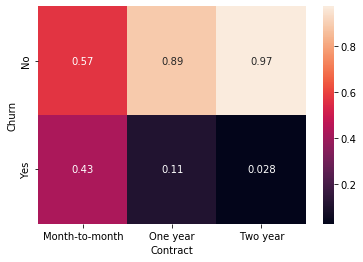

In [59]:
ax = sns.heatmap(mean_matrix('Contract'), annot=True)

This plot shows that for Churn==Yes (lower row) the most of them come from the Month-to-month category, indicating that user who pay month-to-month are more susceptible to churn. We could make a bold claim and say that if ONLY the Contract was the determining factor and not other features, we could save about 30% of the month-to-month group if our services would improve in that category similarly to other groups. Or if we would be able to convert all users in that category to the one-year contract.

In [60]:
churn_df.Contract.value_counts()['Month-to-month']*(0.427-0.1126)

1218.3

About 1200 Churners would have been prevented! that is a whole lot! obviously to mention that this is only true if the Contract was the ONLY feature that would make a change.

To make a bar plot we first need some more data wrangling, we create the following view so seaborn can create the stacked bar plot.

In [61]:
vis_matrix = mean_matrix('Contract').T.reset_index()
vis_matrix['sum'] = 1
vis_matrix

Churn,Contract,No,Yes,sum
0,Month-to-month,0.572903,0.427097,1
1,One year,0.887305,0.112695,1
2,Two year,0.971681,0.028319,1


With this visualisation matrix we have not only no and yes for churn as features, but also the sum. There are other methods to obtain the stacked bar chart but the result is the same.

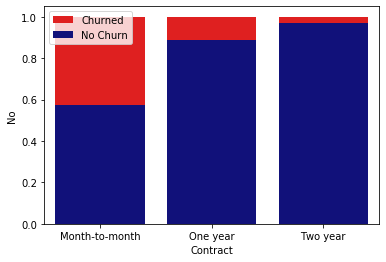

In [62]:
sns.barplot(x="Contract", y="sum", data=vis_matrix, color='red', label='Churned')
sns.barplot(x="Contract",  y="No", data=vis_matrix, color='darkblue', label='No Churn')
plt.legend()
plt.show()

I like to think that this graph clearly displays the disparity between different contracts and the relation to Churning, the red portion indications the percentage of churned customers, keep in mind that some categories might not be large so a larger portion of churners is not as detrimental in that case, but as we saw earlier about 1200 churners could have been prevented if the proportions for month-to-month contract would be the same.

We can perform a similar result for online security.

In [63]:
chi2_results['OnlineSecurity']['diff']

OnlineSecurity,No,No internet service,Yes
Churn,,,
No,-532.736192,291.954423,240.781769
Yes,532.736192,-291.954423,-240.781769


In [64]:
mean_matrix('OnlineSecurity')

OnlineSecurity,No,No internet service,Yes
Churn,,,
No,0.582333,0.92595,0.853888
Yes,0.417667,0.07405,0.146112


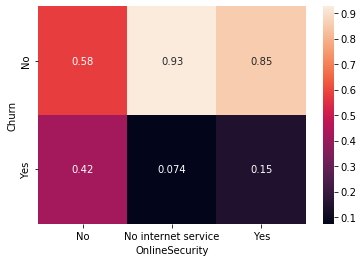

In [65]:
ax = sns.heatmap(mean_matrix('OnlineSecurity'), annot=True)

In [66]:
churn_df.OnlineSecurity.value_counts()['No']*(0.417-0.146)

947.9580000000001

In [67]:
vis_matrix = mean_matrix('OnlineSecurity').T.reset_index()
vis_matrix['sum'] = 1
vis_matrix

Churn,OnlineSecurity,No,Yes,sum
0,No,0.582333,0.417667,1
1,No internet service,0.925950,0.074050,1
2,Yes,0.853888,0.146112,1


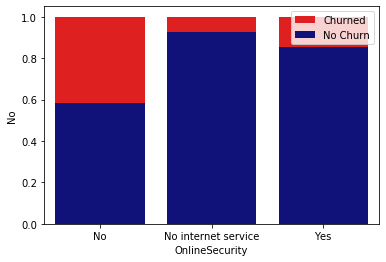

In [68]:
sns.barplot(x="OnlineSecurity", y="sum", data=vis_matrix, color='red', label='Churned')
sns.barplot(x="OnlineSecurity",  y="No", data=vis_matrix, color='darkblue', label='No Churn')
plt.legend()
plt.show()

Again a big difference in groups, this time we could have saved about 950 churners if we would have convinced users that no online security is a bad idea.

### Numerical vs Categorical correlation

When visualising numerical and categorical correlation it usually comes down to histograms. Here I will look into MonthlyCharges and tenure.
For a refreshment we group per churn and print the averages.

In [69]:
churn_df.groupby('Churn')[['tenure', 'MonthlyCharges', 'TotalCharges']].mean()

,tenure,MonthlyCharges,TotalCharges
Churn,,,
No,37.569965,61.265124,2549.911442
Yes,17.979133,74.441332,1531.796094


The trick for histograms with different categories is to overlap multiple histograms, we seperate our dataset into churned and nochurn and plot both results.

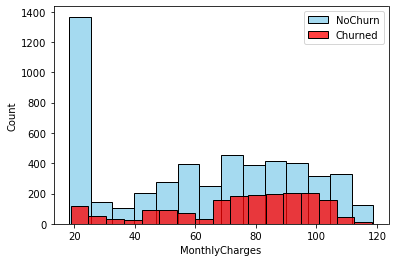

In [70]:
sns.histplot(x=churn_df[churn_df.Churn=='No'].MonthlyCharges, color="skyblue", label="NoChurn")
sns.histplot(x=churn_df[churn_df.Churn=='Yes'].MonthlyCharges, color="red", label="Churned")
plt.legend()
plt.show()

For monthly charges we can see that although there was a significant difference found by ANOVA and the means are different, the distributions look alike. The culprit behind this is probably the long peak of no churn in the beginning, the dataset seems to have a lot of small customers that are happy with their services as the price is low. A good example how with non normal data we should not simply rely on mathematics to say something is significant!

Perhaps to overcome non normality we could opt for the median instead of the mean.

In [71]:
churn_df.groupby('Churn')[['tenure', 'MonthlyCharges', 'TotalCharges']].median()

,tenure,MonthlyCharges,TotalCharges
Churn,,,
No,38.0,64.425,1679.525
Yes,10.0,79.650,703.550


Although the values have changed (indicating again non normal data) we see that the difference is still present, so our non normality has not been 'solved'. We are warned.

Similar to the previous plot, we create a histogram for tenure

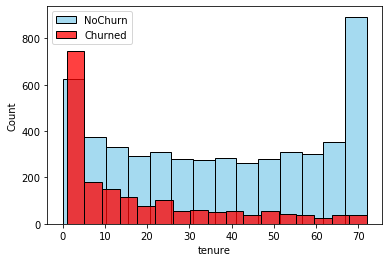

In [72]:
sns.histplot(x=churn_df[churn_df.Churn=='No'].tenure, color="skyblue", label="NoChurn")
sns.histplot(x=churn_df[churn_df.Churn=='Yes'].tenure, color="red", label="Churned")
plt.legend() 
plt.show()

This looks really great! we can see that churned users usually have a lower tenure, perhaps onboarding of new customers is a problem?

### Unsupervised clustering

Similar to the churn feature, we can also use the cluster feature, basically the same method, but a different outcome.

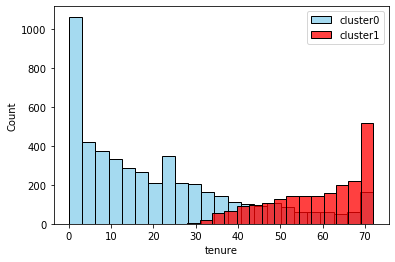

In [73]:
sns.histplot(x=churn_cluster_df[churn_cluster_df.cluster==0].tenure, color="skyblue", label="cluster0")
sns.histplot(x=churn_cluster_df[churn_cluster_df.cluster==1].tenure, color="red", label="cluster1")
plt.legend() 
plt.show()

Here you can see the power of clustering, the algorithm clearly used the tenure as a input to determine the clusters. cluster 1 contains most of the longer customers (that all have internet and most of them phone service).

In case of montly charges we also see a big difference.

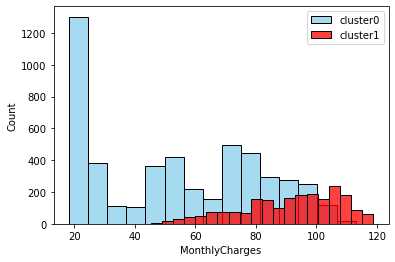

In [74]:
sns.histplot(x=churn_cluster_df[churn_cluster_df.cluster==0].MonthlyCharges, color="skyblue", label="cluster0")
sns.histplot(x=churn_cluster_df[churn_cluster_df.cluster==1].MonthlyCharges, color="red", label="cluster1")
plt.legend() 
plt.show()

cluster 1 again contains the higher paying customers, which is explainable as they mostly all have phone and internet. These customers might be 'sleeping' as they are not aware of higher charges.

To show the phone services I created a simple heatmap.

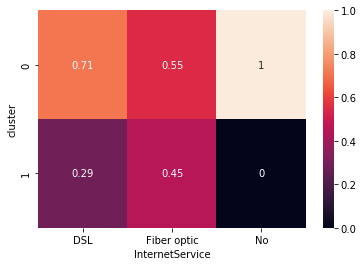

In [75]:
ax = sns.heatmap(mean_cluster_matrix('InternetService'), annot=True)

It shows in which cluster the internet users are, again all users that have no internet are in cluster 0.

### K Nearest Neighbours

Illustrating a machine learning algorithm is always difficult, a we are dealing with categorical variables it is exceptionally hard.

The only thing I can think of here is to create a heatmap from the confusion matrix, with a logarithmic scale.

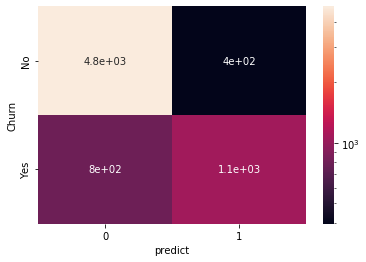

In [76]:
from matplotlib.colors import LogNorm
ax = sns.heatmap(conf_matrix, annot=True,  norm=LogNorm())

Not great, but shows that the false positives (no churnes that are flagged) and false negatives (churners that not have been flagged) are fairly low.

### Summary

At this point it would be a good idea to reconnect with our client and discuss our results.

In our analysis we found some significant difference for churners, being:
- A short tenure
- Having a month-to-month contract 
- Not having additional options on services
- Senior Citizenship


To prevent this they could for example:
- Give attention to new customers, create a better onboarding
- Create promotion/discount for longer subscription plans
- Create promotion/discount on additional services
- Improve elpdesk for less technology abled persons

When we cluster the customers in 2 groups, we did not find a clear overlap with the churn parameter, however it seems the second cluster found customers that have higher tenures and more additional services.
Looking at Charges, this cluster had a significantly higher amount, indicating that the most profitable customers belong to this cluster.

A (simple) machine learning exercise has shown there is a possibility of having a 75% accuracy (amount of flagged users that is actually a churner) and a recall of 57% (amount of churners that is found by the algorithm).
These results are not great, but not bad either, further improvements might be needed but this implementation is not critical, i.e. flagging a user as a churner whilst he/she is not, is not necessary crucial for operation.